# Notebooks: Baselines models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sbn

sbn.set()

## Load the dataset

In [3]:
from ceruleo.dataset.catalog.CMAPSS import CMAPSSDataset

2022-08-11 14:38:02.949070: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-11 14:38:02.951705: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-11 14:38:02.951713: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
from sklearn.model_selection import train_test_split

dataset = CMAPSSDataset(train=True, models='FD001')
train_dataset, test_dataset = train_test_split(dataset, train_size=0.8)

## Create a transformer

In [5]:
from ceruleo.transformation.functional.transformers import Transformer
from ceruleo.transformation.features.selection import ByNameFeatureSelector
from ceruleo.transformation.functional.pipeline.pipeline import make_pipeline
from ceruleo.transformation.features.scalers import MinMaxScaler
from ceruleo.dataset.catalog.CMAPSS import sensor_indices
from ceruleo.iterators.utils import true_values

FEATURES = [train_dataset[0].columns[i] for i in sensor_indices]


In [6]:

transformer = Transformer(
    pipelineX=make_pipeline(
        ByNameFeatureSelector(features=FEATURES), 
        MinMaxScaler(range=(-1, 1))

    ), 
    pipelineY=make_pipeline(
        ByNameFeatureSelector(features=['RUL']),  
    )
)

transformer.fit(train_dataset)

transformed_train_dataset = train_dataset.map(transformer)
transformed_test_dataset = test_dataset.map(transformer)

### Baseline model

In [7]:
from ceruleo.models.baseline import BaselineModel
model_mean = BaselineModel(mode='mean')
model_mean.fit(transformed_train_dataset)

model_median = BaselineModel(mode='median')
model_median.fit(transformed_train_dataset)

<class 'ceruleo.dataset.transformed.TransformedDataset'>
<class 'ceruleo.dataset.transformed.TransformedDataset'>


### Fixed Value Baseline Model

In [8]:
from ceruleo.models.baseline import FixedValueBaselineModel
model_fixed = FixedValueBaselineModel(value=100)


###  Results

<class 'ceruleo.dataset.transformed.TransformedDataset'>
<class 'ceruleo.dataset.transformed.TransformedDataset'>
<class 'ceruleo.dataset.transformed.TransformedDataset'>
<class 'ceruleo.dataset.transformed.TransformedDataset'>


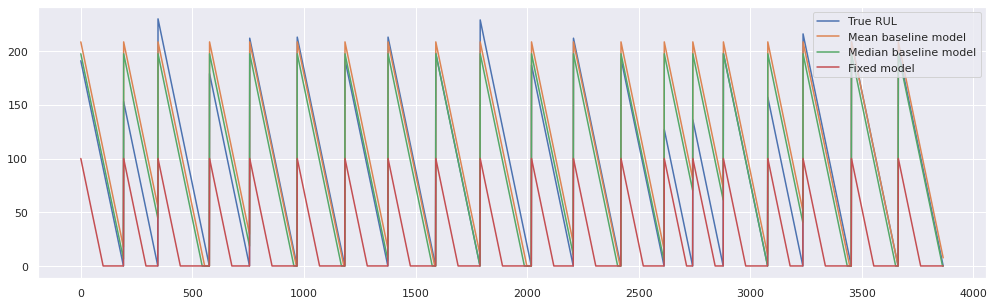

In [9]:
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(true_values(transformed_test_dataset), 
        label='True RUL')
ax.plot(model_mean.predict(transformed_test_dataset), 
        label='Mean baseline model')
ax.plot(model_median.predict(transformed_test_dataset), 
        label='Median baseline model')
ax.plot(model_fixed.predict(transformed_test_dataset), 
        label='Fixed model')
ax.legend()